In [28]:
from pygam import GAM, s, te

GAM(s(0, n_splines=200) + te(3,1) + s(2), distribution='poisson', link='log')


GAM(callbacks=['deviance', 'diffs'], distribution='poisson', 
   fit_intercept=True, link='log', max_iter=100, 
   terms=s(0) + te(3, 1) + s(2), tol=0.0001, verbose=False)

In [29]:
from pygam import PoissonGAM, s, te
from pygam.datasets import chicago

X, y = chicago(return_X_y=True)

gam = PoissonGAM(s(0, n_splines=200) + te(3, 1) + s(2)).fit(X, y)

In [30]:
from pygam import LinearGAM, s
from pygam.datasets import toy_interaction

X, y = toy_interaction(return_X_y=True)

gam = LinearGAM(s(0, by=1)).fit(X, y)
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      20.854
Link Function:                     IdentityLink Log Likelihood:                              -2314375.3964
Number of Samples:                        50000 AIC:                                          4628794.5008
                                                AICc:                                         4628794.5208
                                                GCV:                                                  0.01
                                                Scale:                                                0.01
                                                Pseudo R-Squared:                                   0.9976
Feature Function                  Lam

/tmp/ipykernel_640322/427681795.py:7: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


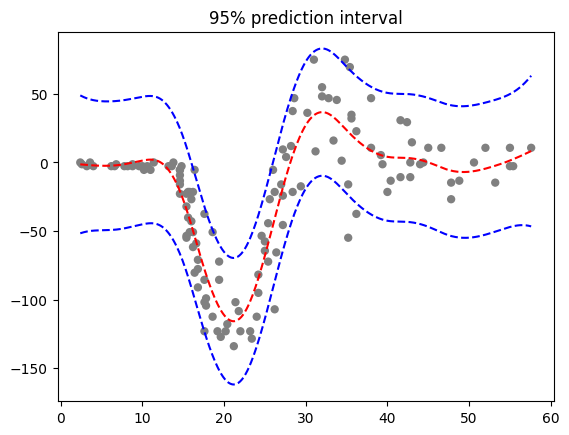

In [31]:
from pygam import LinearGAM
from pygam.datasets import mcycle

X, y = mcycle(return_X_y=True)

gam = LinearGAM(n_splines=25).gridsearch(X, y)
XX = gam.generate_X_grid(term=0, n=500)

plt.plot(XX, gam.predict(XX), 'r--')
plt.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--')

plt.scatter(X, y, facecolor='gray', edgecolors='none')
plt.title('95% prediction interval');

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Text(0.5, 1.0, 'draw samples from the posterior of the coefficients')

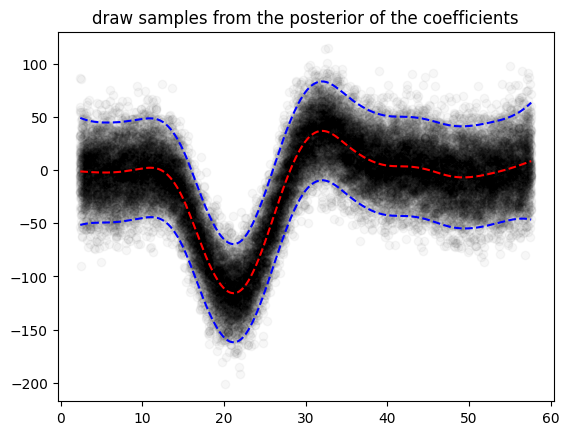

In [32]:
# continuing last example with the mcycle dataset
for response in gam.sample(X, y, quantity='y', n_draws=50, sample_at_X=XX):
    plt.scatter(XX, response, alpha=.03, color='k')
plt.plot(XX, gam.predict(XX), 'r--')
plt.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--')
plt.title('draw samples from the posterior of the coefficients')


# **Big Data**
In this tutorial we'll look at using the Stochastic Variational Gaussian Process (SVGP) model as an approximate Gaussian Process (GP) model. This will allow us to tackle big datasets that are way outside the practical range of the exact model.

## **Stochastic Variational Gaussian Processes**
Stochastic Variational Gaussian Processes are an approach to scale GPs using a variational inducing point framework. They can extend GPs to datasets with with millions of subjects. A full discussion is beyond the scope of this tutorial, but for our purposes we can think of them as having the same assumptions as the exact GP model (homoskedasticity and gaussian noise) and keep in mind that the training is stochastic. We will look at the parameters available to adjust the model training and compare some results with the exact model.

For those who are looking for a deeper introduction there are resources provided at the end of the tutorial.


## **Example 1**
In this example we will use a dataset with a couple thousand subjects to compare the results of fitting the exact and approximate GP models. With this many subjects the exact model will take more time, but should still manageable on a laptop. The gains from the approximate model will become very clear on larger datasets.

Here we are using a dataset with:
- Multiple confounds (explanatory variables) (age, sex & site)
- Homoskedastic variance across the explanatory variable within each site
- Gaussian noise
- A random offset in score for probands pulled from the gaussian distribution
- A random offset in score for sex pulled from the gaussian distribution
- A random offset in score for site pulled from the gaussian distribution (constant for all subjects from same site)

In [2]:
def g(age, sex, offset, prob = False):
    noise = np.random.normal(0, 0.1)
    if prob:
        return 0.001*age-0.00001*(age-50)**2+0.5 + noise - np.random.uniform(0, 0.2) * sex - 0.08 * np.random.uniform() + offset
    else:
        return 0.001*age-0.00001*(age-50)**2+0.5 + noise - np.random.uniform(0, 0.2) * sex + offset

def dataset_multivariate(n_sites=5,sample_size=35,seed=650):
    np.random.seed(seed)
    n_sites = n_sites
    age_min = (np.random.rand(n_sites)*50).astype(int)
    sites = pd.DataFrame(data={'sex_ratio': np.random.rand(n_sites),
                               'prob_ratio': 0.5*np.random.rand(n_sites),
                               'age_min': age_min,
                               'age_max': (age_min+5+np.random.rand(n_sites)*50).astype(int),
                               'score_shift': np.random.randn(n_sites)/10,
                               'sample_size': (sample_size+np.random.rand(n_sites)*sample_size*10).astype(int)})

    participants = []
    for site in sites.iterrows():
        for participant in range(int(site[1]['sample_size'])):
            sex = np.random.binomial(1, site[1]['sex_ratio'])
            prob = np.random.binomial(1, site[1]['prob_ratio'])
            age = np.random.uniform(site[1]['age_min'], site[1]['age_max'])
            score = g(age, sex, site[1]['score_shift'],prob=prob)
            participants.append([site[0], sex, prob, age, score])

    df = pd.DataFrame(participants, columns=['site', 'sex', 'status', 'age', 'score'])
    return df

In [3]:
# Create a dataset
df = dataset_multivariate(n_sites=4,sample_size=200,seed=777)
print('n subjects = {}'.format(df.shape[0]))

n subjects = 2784


### Visualize data
Here we'll look at the data as we usually do (by PROB/CTR), but we'll also explore the effect of the confounds by looking at the data plotted by site and sex.

Text(0.5, 1.0, 'By sex')

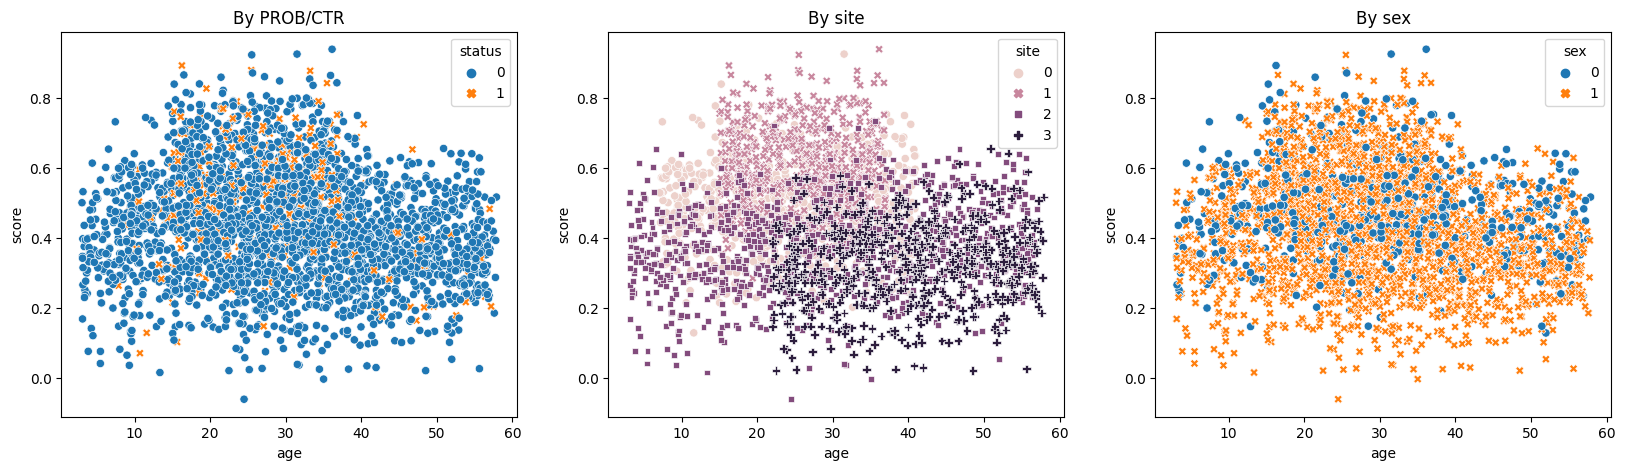

In [4]:
fig,ax = plt.subplots(1,3,figsize=(20,5))

sns.scatterplot(data=df, x='age', y='score', hue='status', style='status',ax=ax[0])
sns.scatterplot(data=df, x='age', y='score', hue='site', style='site',ax=ax[1])
sns.scatterplot(data=df, x='age', y='score', hue='sex', style='sex',ax=ax[2])

ax[0].set_title('By PROB/CTR')
ax[1].set_title('By site')
ax[2].set_title('By sex')

In the case of categorical confounds, it is useful to take a look at the distribution of the data within each category using violin plots. Here we can clearly see the offset in score associated with each site and sex. This will serve as a useful point of comparison when we take a look at the deviance scores from our models.

Text(0.5, 1.0, 'By sex')

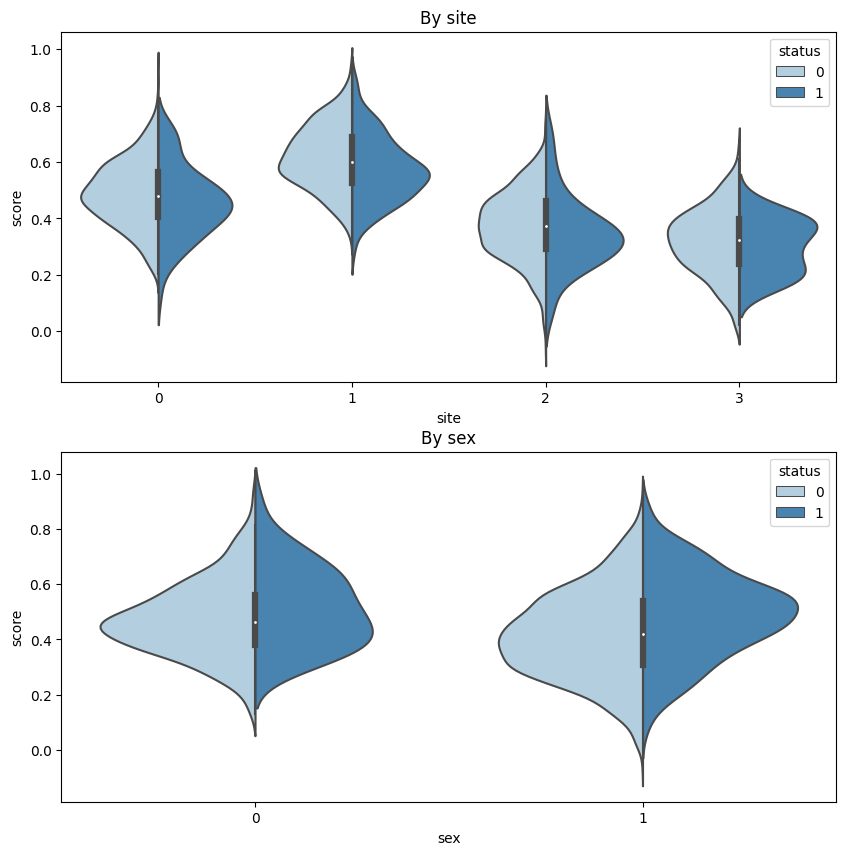

In [5]:
fig,ax = plt.subplots(2,1,figsize=(10,10))

sns.violinplot(x='site',y='score',data=df,split=True,palette='Blues',hue='status',ax=ax[0])
sns.violinplot(x='sex',y='score',data=df,split=True,palette='Blues',hue='status',ax=ax[1])

ax[0].set_title('By site')
ax[1].set_title('By sex')

### Fit exact GP model

In [6]:
# Initialize pynm w/ data, confounds
m = PyNM(df,'score','status',['age','c(sex)','c(site)'])

Models will be fit on full set of controls.


By default PyNM decided if it should use the exact or approximate GP model based on the number of subjects in the dataset. Here we will force it to use the exact model with the `method` parameter and we will receive a warning.

In [7]:
# Run & time model
start = time.time()

m.gp_normative_model(method='exact')

dur = time.time() - start

print('Model fit in {:.3f}s'.format(dur))

/home/user/anaconda3/envs/gamlss39/lib/python3.9/site-packages/pynm/pynm.py:503: Warning: Exact GP model with over 2000 data points requires large amounts of time and memory, continuing with exact model.
  warnings.warn("Exact GP model with over 2000 data points requires "
/home/user/anaconda3/envs/gamlss39/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fit in 28.562s


As in the last tutorial, looking at the plots of deviance scores by category shows that the GP has modeled the site and sex effects well (scores distributed about 0).

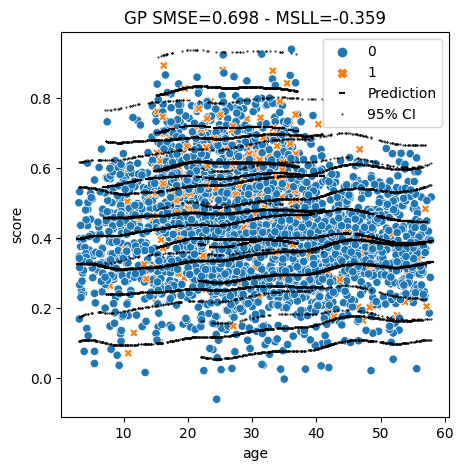

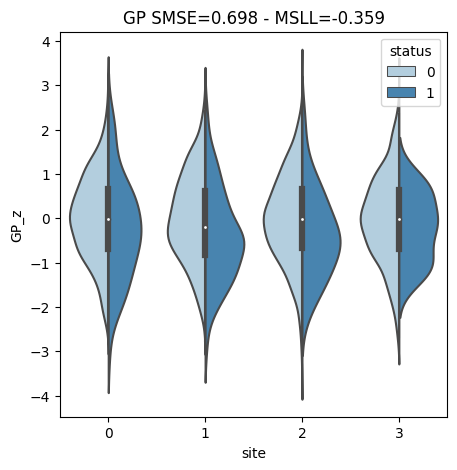

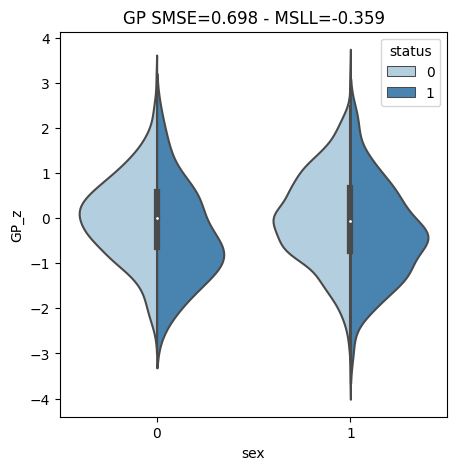

In [8]:
# Plot the data, model prediction, & 95% confidence interval
m.plot()

# Plot the z-scores of the model (model residuals / std deviation)
m.plot_z(confound='site')
m.plot_z(confound='sex')

### Fit approximate GP with default hyperparameters

In [9]:
# Initialize pynm w/ data, confounds
m_approx = PyNM(df,'score','status',['age','c(sex)','c(site)'])

Models will be fit on full set of controls.


In [16]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

We already gain significant speed over the exact model on a dataset of a couple thousand subjects!

In [17]:

# Run & time model
start = time.time()
#device = torch.device("GPU:0")
m_approx.gp_normative_model(method='approx')#.to(device)

dur = time.time() - start

print('Model fit in {:.3f}s'.format(dur))

Epoch:   0%|                                                                                                      | 0/20 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument tensors in method wrapper_cat)

However, looking at the model fit we can see that the confidence interval (CI) is overly large. We an adjust the fit using the hyperparameters `num_epochs`, and  `batch_size`.

In [ ]:
# Plot the data, model prediction, & 95% confidence interval
m_approx.plot()

# Plot the z-scores of the model (model residuals / std deviation)
m_approx.plot_z(confound='site')
m_approx.plot_z(confound='sex')

### Fit approximate GP with custom hyperparameters

In [18]:
# Initialize pynm w/ data, confounds
m_approx2 = PyNM(df,'score','status',['age','c(sex)','c(site)'])

Models will be fit on full set of controls.


In [19]:
# Run & time model
start = time.time()

m_approx2.gp_normative_model(method='approx',num_epochs=50,batch_size=64)

dur = time.time() - start

print('Model fit in {:.3f}s'.format(dur))

Epoch:   0%|                                                                                                      | 0/50 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument tensors in method wrapper_cat)

We've improved the fit of our approximate model by reducing the `batch_size` and increasing the `num_epochs`. This allows it to train more finely and for longer. 

We still don't have as nice a fit as with our exact model. Ideally we would like to use our exact model for as long as we have the resources to, but looking at the deviance scores by category shows that we are still correcting well for our confounds. In the next example we'll see a dataset for which the exact model is completely impractical and the approximate model achieves a much better fit (the more data, the less overfitting).

/home/user/anaconda3/envs/gamlss39/lib/python3.9/site-packages/pynm/pynm.py:982: UserWarning: No model results found in data.
  warnings.warn('No model results found in data.')


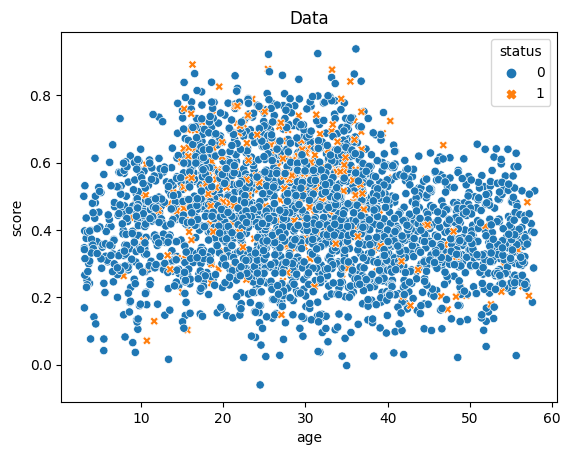

ValueError: No model deviance scores found in data.

In [20]:
# Plot the data, model prediction, & 95% confidence interval
m_approx2.plot()

# Plot the z-scores of the model (model residuals / std deviation)
m_approx2.plot_z(confound='site')
m_approx2.plot_z(confound='sex')

## **Example 2**
In this example we will use a dataset with ~25000 subjects to illustrate a case where the approximate model handles the computation easily, whereas using the exact model would require a massive amount of memory and time.

Here we are using a dataset with:
- A single explanatory variable (age)
- Homoskedastic variance across the explanatory variable
- Gaussian noise
- A random offset in score for probands pulled from the gaussian distribution

In [21]:
# Define Functions
def sample_x(low=1,high=100,n_subs=1000,sampling='full'):
    if sampling =='full':
        x = np.random.uniform(low=low,high=high,size=n_subs)
    else:
        x = np.concatenate([np.random.normal(20,10,size=int(n_subs/2)),np.random.normal(80,10,size=int(n_subs/2))])
        x = x[(x<high) & (x > low)]
    return x
    
def f(x):
    return np.log(x) + np.random.randn()

def dataset(seed=10,sampling='full',n_subs=1000):
    # Set seed
    np.random.seed(seed)

    # Age param
    x = np.sort(sample_x(sampling=sampling,n_subs=n_subs))

    # PROB = 1/CTR = 0
    status =  np.random.binomial(1,0.01,size=x.shape[0])

    # Score param
    score = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        s = f(x[i])

        # Random offset for probands
        s = s + status[i]*np.random.normal(0.2,1.2)

        score[i] = s

    return pd.DataFrame([x,status,score],index=['age','status','score']).transpose()

In [22]:
# Create a dataset
df_xl = dataset(n_subs=25000)
print('n subjects = {}'.format(df_xl.shape[0]))

n subjects = 25000


### Visualize data

<AxesSubplot: xlabel='age', ylabel='score'>

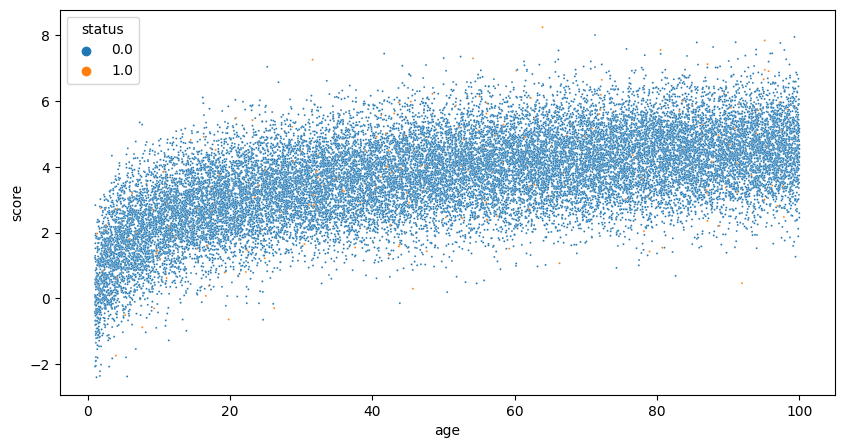

In [23]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='age',y='score',hue='status',data=df_xl,s=2)

### Fit approximate GP on extra large dataset

In [24]:
# Initialize pynm w/ data and confounds
m_xl = PyNM(df_xl,'score','status',['age'])

Models will be fit on full set of controls.


In [25]:
# Run & time model
start = time.time()

m_xl.gp_normative_model(method='approx')

dur = time.time() - start

print('Model fit in {:.3f}s'.format(dur))

Epoch:   0%|                                                                                                      | 0/20 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument tensors in method wrapper_cat)

We successfully fit a model to the data in about 70 seconds (running on a laptop with 16GB RAM), that would be impossible with the exact model on the same hardware.

In [ ]:
# Plot the data, model prediction, & 95% confidence interval
m_xl.plot()

# Plot the z-scores of the model (model residuals / std deviation)
m_xl.plot_z()

## **Summary**
- SVGPs are an approximation to GPs that can scale up to large datasets.
- We can choose which model to use with the `method` parameter of `gp_normative_model`
- By default (`method='auto'`) PyNM will select the model based on the number of subjects in the dataset.
- We can set `method` to `'exact'` or `'approx'` to override the default choice.
- The SVGP model training is controlled by the `num_epochs` and `batch_size` parameters, which we can play with to tune the model fit along with the `length_scale` and `length_scale_bounds` parameters we saw in tutorial 3.

## **Resources**
- GPyTorch's Stochastic Variational GP Regression [documentation](https://docs.gpytorch.ai/en/v1.1.1/examples/04_Variational_and_Approximate_GPs/SVGP_Regression_CUDA.html)
- Hensman et al. arXiv 2015, [Scalable Variational Gaussian Process Classification](https://arxiv.org/abs/1411.2005)
- Blei et al. Journal of the American Statistical Association 2016, [Variational Inference: A Review for Statisticians](https://arxiv.org/abs/1601.00670)

### **Next up:** Normative modeling on complex data using a GAMLSS!